In [118]:
import numpy as np

In [119]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [120]:
def plot_distribution(ax, pdfs, title=''): 
    x = np.linspace(0., 10., 200)
    ymax = 0    
    for index, pdf in enumerate(pdfs):
        y = norm.pdf(x, pdf.mean, np.sqrt(pdf.var))

        p = ax.plot(x, y, lw = 2)
        c = p[0].get_markeredgecolor()    
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )    
        ax.autoscale(tight=True)
        ax.vlines(pdf.mean, 0, y.max(), colors = c, linestyles = "--", lw = 2)    

        ymax = max( ymax, y[1:].max()*1.05 )
    ax.set_ylim([0,ymax])

def plot_regret(ax, regret, title=''): 
    ax.plot(regret)

def plot(regret, mab):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_regret(axs[0], regret)
    plot_distribution(axs[1], mab)

In [121]:
class Arm:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

    def sample(self):
        return np.random.normal(self.mean, np.sqrt(self.var))

    def name(self):
        return 'N(' + str(self.mean) + ',' + str(self.var) + ')'

# Thompson Sampling

In this exercise we will run thompson sampling for 2-armed bandit with gaussian distribution.
For simplicity assume we know variance of distribution of arms and only mean is unknown
for prior assume gaussian distribution.

## 1.
If variance was unknown what prior distribution would be suitable?

An Inverse Gamma distribution or a Gamma distribution would be suitable for prior of the variance.

## 2.
Implement Thompson Sampling algorithm. For comparison also implement ϵ-Greedy and UCB algorithms

In [122]:
class ThompsonSampling:
    def __init__(self, vars, **kwargs):
        """
        variance of arms are known to policy
        """
        self.dist_lambda = 1 / np.array(vars)  # lambda is inverse of variance
        self.mu_prior = np.zeros_like(self.dist_lambda)
        self.lambda_prior = np.ones_like(self.dist_lambda) / 10


    def select_arm(self, *args):
        # select arm based on estimate of prior distribution
        # return index of selected arm
        return np.argmax(np.random.normal(np.random.normal(self.mu_prior, np.sqrt(1 / self.lambda_prior))))


    def update(self, idx, reward):
        # update prior based on reward
        lambda_posterior = self.lambda_prior[idx] + self.dist_lambda[idx]
        mu_posterior = (self.lambda_prior[idx] * self.mu_prior[idx] + self.dist_lambda[idx] * reward) / lambda_posterior
        self.lambda_prior[idx] = lambda_posterior
        self.mu_prior[idx] = mu_posterior

In [134]:
class UCB:    
    def __init__(self, n_bandits, c_level):
        """
        c_level: coefficient of uncertainty
        """
        self.n_bandits = n_bandits
        self.c_level = c_level
        self.n = np.zeros(n_bandits)
        self.Q = np.zeros(n_bandits)
        
    
    def select_arm(self, t):
        """
        t: step time
        """
        # select arm based on UCB
        # return index of selected arm
    
        return np.argmax(self.Q + self.c_level * np.sqrt(np.log(t + 1) / (self.n + 1e-5)))
        

    def update(self, idx, reward):
        # update based on reward
        self.Q[idx] = (self.n[idx] * self.Q[idx] + reward) / (self.n[idx] + 1)
        self.n[idx] += 1

In [124]:
class eGreedy:    
    def __init__(self, n_bandits, epsilon):
        """
        epsilon must be given
        """
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.Q = np.zeros(n_bandits)
        self.n = np.zeros(n_bandits)

        
    
    def select_arm(self, *args):
        # select arm based on e-Greedy
        # return index of selected arm
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_bandits)
        return np.argmax(self.Q)
    

    def update(self, idx, reward):
        # update based on reward
        self.Q[idx] = (self.n[idx] * self.Q[idx] + reward) / (self.n[idx] + 1)
        self.n[idx] += 1

## 3
run simulation for arms described as cells below and describe the differences of regret with different variance in arms distributions

rum_sim1 must return cumulitive regret formulated as 
$$
R(T)=\sum_{i=1}^2 N_i(T) \Delta_i
$$

where $N_i(T)$ is number of times arm $i$ was selected until step $T$, $\Delta_i=\mu^*-\mu_i$, $\mu^*$ is largest mean in arms distribtions and $\mu_i$ is mean of distribution of arm $i$

to get average regret we rum simulation 50 times.

In [125]:
def run_sim1(policy, mab, step_num=100):
    """
    run simulation of multi-armed bandit
    mab: list of arms
    """
    best_mean = np.max([b.mean for b in mab])
    regrets = []
    for k in range(step_num):      
        # run policy algorithm and return cumulative regret
        idx = policy.select_arm(k)
        reward = mab[idx].sample()
        policy.update(idx, reward)
        regret = best_mean - reward
        # print(f'step: {k}, regret: {regret}')
        regrets.append(regret)
    return regrets

### 3.1
Assume Multi-Armed Bandit variables are as follows.

In [141]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]

#### Thompson Sampling
run and describe the result.

sum of regret: 16.83535423691442


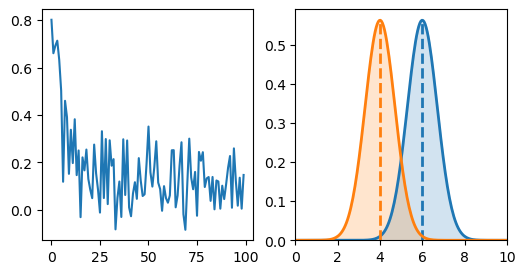

In [143]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
mean_regret = np.mean(regret, axis=0)
print(f'sum of regret: {np.sum(mean_regret)}')
plot(mean_regret, mab)

#### ϵ-Greedy
run for different values of ϵ and compare results.

sum of regret: 6.671863344787513


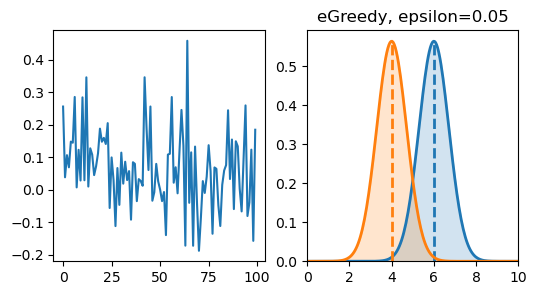

sum of regret: 12.057845709425115


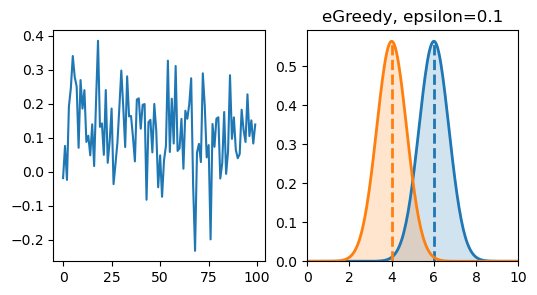

sum of regret: 20.869838511374464


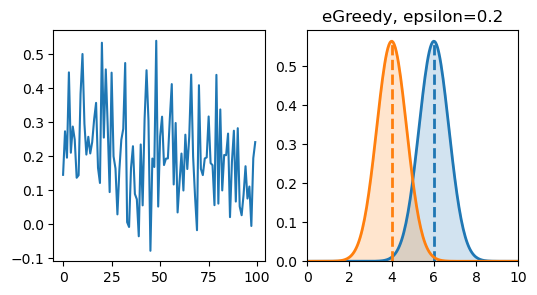

sum of regret: 41.011763677572645


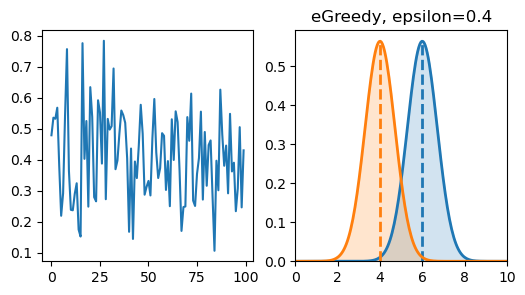

sum of regret: 52.63085714972619


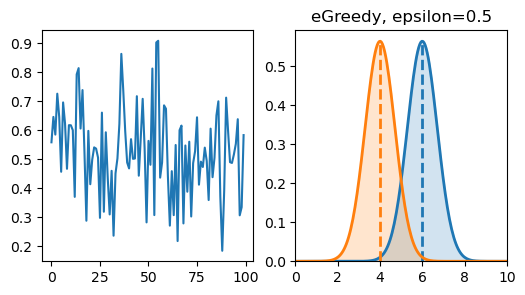

In [132]:
epsilon_candidates = [0.05, 0.1, 0.2, 0.4, 0.5]
for epsilon in epsilon_candidates:
    regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
    mean_regret = np.mean(regret, axis=0)
    print(f'sum of regret: {np.sum(mean_regret)}')
    plot(mean_regret, mab)
    plt.title(f'eGreedy, epsilon={epsilon}')
    plt.show()

Smaller epsilons achieve better total regret.

#### UCB
run for different values of confidence level and compare results.


sum of regret: 2.752528787838971


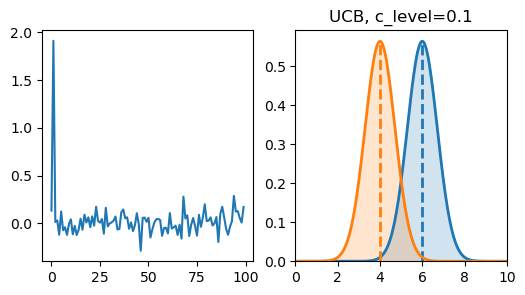

sum of regret: 2.8108910365210398


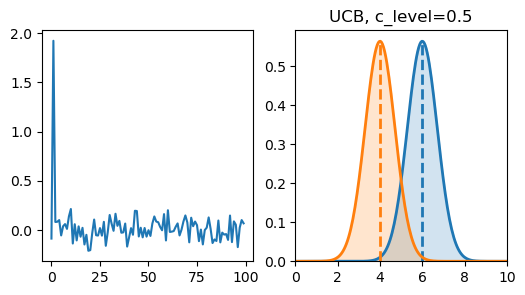

sum of regret: 2.1851784971542814


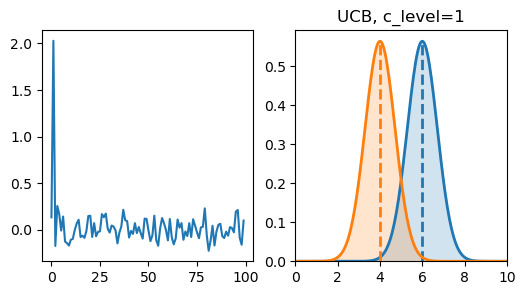

sum of regret: 6.240608771909641


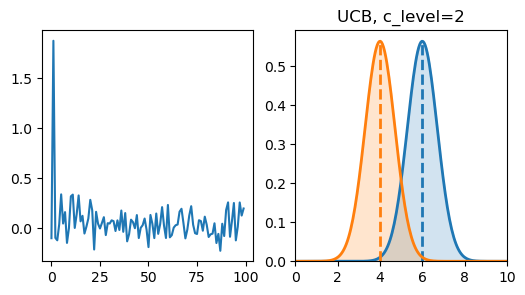

sum of regret: 24.13648396946633


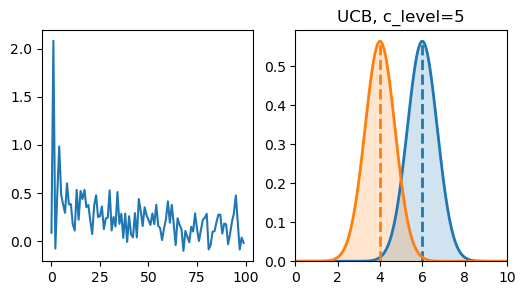

In [135]:
c_level_candidates = [0.1, 0.5, 1, 2, 5]
for c_level in c_level_candidates:
    regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
    mean_regret = np.mean(regret, axis=0)
    print(f'sum of regret: {np.sum(mean_regret)}')
    plot(mean_regret, mab)
    plt.title(f'UCB, c_level={c_level}')
    plt.show()

From the above methods, UCB converges fastest and achieves the lowest total regret.

### 3.2
Assume Multi-Armed Bandit variables are as follows.

In [136]:
mab = [Arm(6, 10), Arm(4, 10)]

#### Thompson Sampling
run and compare results.

sum of regret: 82.74922865345009


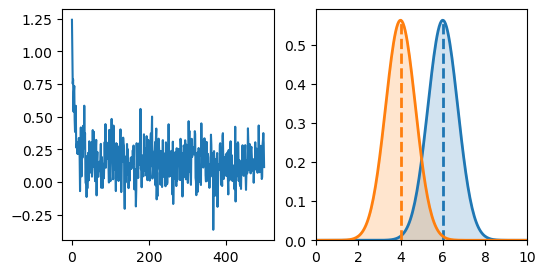

In [147]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab, step_num=500) for _ in range(50)]
mean_regret = np.mean(regret, axis=0)
print(f'sum of regret: {np.sum(mean_regret)}')
plot(mean_regret, mab)

#### ϵ-Greedy
run for different values of ϵ and compare results.

sum of regret: 7.21389327544873


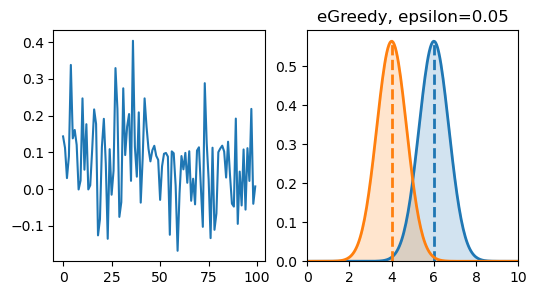

sum of regret: 11.637026561198603


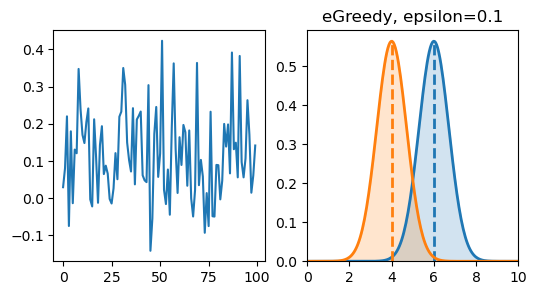

sum of regret: 18.852532911532805


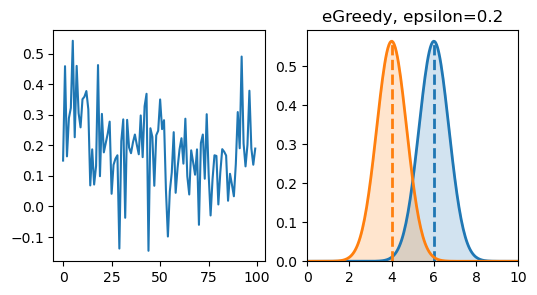

sum of regret: 41.0697470650756


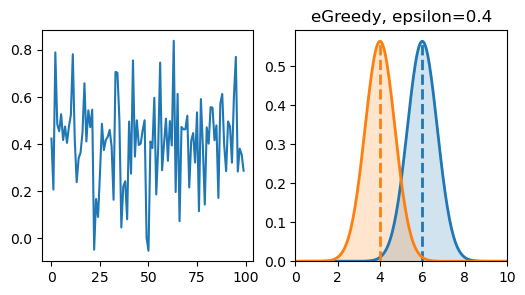

sum of regret: 51.51334028938019


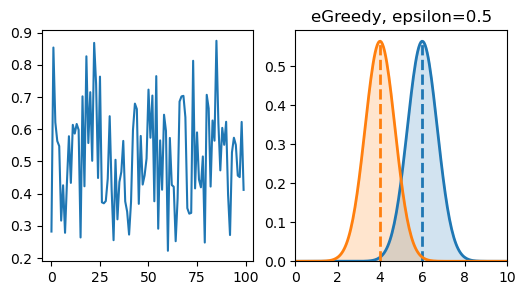

In [145]:
epsilon_candidates = [0.05, 0.1, 0.2, 0.4, 0.5]
for epsilon in epsilon_candidates:
    regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
    mean_regret = np.mean(regret, axis=0)
    print(f'sum of regret: {np.sum(mean_regret)}')
    plot(mean_regret, mab)
    plt.title(f'eGreedy, epsilon={epsilon}')
    plt.show()

#### UCB
run for different values of confidence level and compare results.

sum of regret: 2.8308478553251653


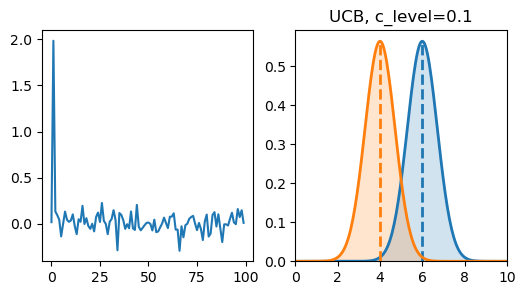

sum of regret: 2.3817831338733795


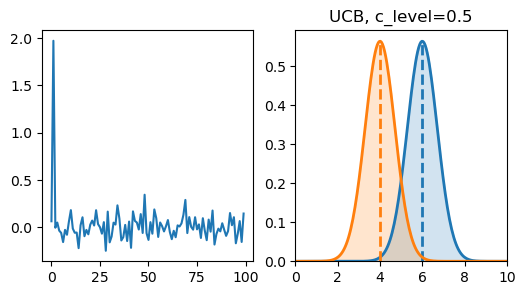

sum of regret: 3.5585512061633984


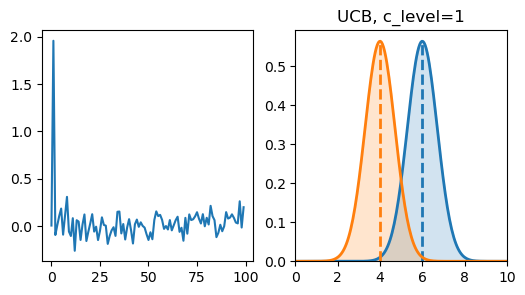

sum of regret: 6.344887046605995


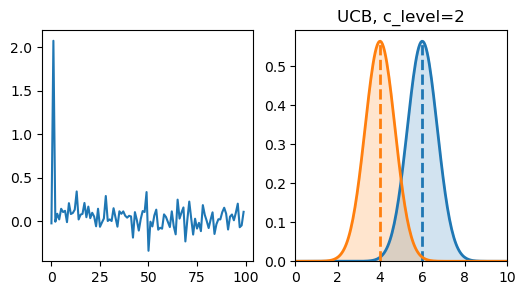

sum of regret: 25.23941751908187


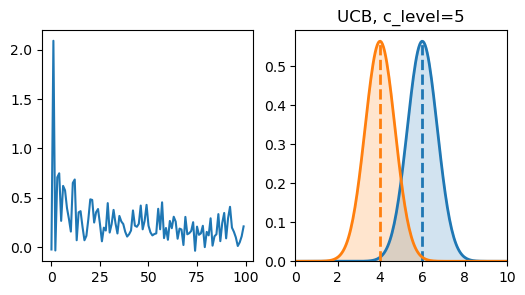

In [146]:
c_level_candidates = [0.1, 0.5, 1, 2, 5]
for c_level in c_level_candidates:
    regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
    mean_regret = np.mean(regret, axis=0)
    print(f'sum of regret: {np.sum(mean_regret)}')
    plot(mean_regret, mab)
    plt.title(f'UCB, c_level={c_level}')
    plt.show()

Again, UCB acts the best.

## 4
simulation below assumes a non-stationary multi-armed bandit. specifically in this simulation mean value of distribution of first arm changes in step 100. describe the result of thompson sampling.

In [148]:
def run_sim2(ts, mab, step_num=200, change_step=100):
    init_mean = mab[0].mean
    best_mean = np.max([b.mean for b in mab])
    regret = []
    for i in range(step_num):
        if i == change_step:
            mab[0].mean = 2
            best_mean = np.max([b.mean for b in mab])
            
        # run tompson sampling algorithm and return cumulative regret
        idx = ts.select_arm(i)
        reward = mab[idx].sample()
        ts.update(idx, reward)
        regret.append(best_mean - reward)
        
    mab[0].mean = init_mean
    return regret

sum of regret: 166.07502960755028


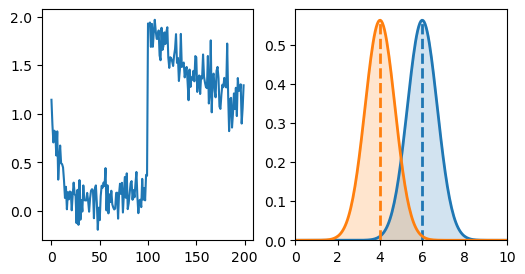

In [168]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
mean_regret = np.mean(regret, axis=0)
print(f'sum of regret: {np.sum(mean_regret)}')
plot(mean_regret, mab)

### 4.1
change thompson sampling algorithm to improve results in non-stationary MAB.

We use a buffer and compute posterior only with the samples in the buffer. This helps to overcome the non-stationarity.

In [177]:
from collections import deque


class NewThompsonSampling:
    def __init__(self, var_list, buffer_size=30, **kwargs):
        self.dist_lambda = 1 / np.array(var_list)  # lambda is inverse of variance
        self.mu_prior = np.zeros_like(self.dist_lambda)
        self.lambda_prior = np.ones_like(self.dist_lambda) / 10
        self.initial_lambda_prior = np.ones_like(self.dist_lambda) / 10
        self.buffers = [deque(maxlen=buffer_size) for _ in range(len(var_list))]
        

    def select_arm(self, *args):
        # select arm based on estimate of prior distribution
        # return index of selected arm
        
        return np.argmax(np.random.normal(np.random.normal(self.mu_prior, np.sqrt(1 / self.lambda_prior))))


    def update(self, idx, reward):
        # update prior based on reward
        self.buffers[idx].append(reward)
        n = len(self.buffers[idx])
        lambda_posterior = self.initial_lambda_prior[idx] + n * self.dist_lambda[idx]
        mu_posterior = (self.dist_lambda[idx] * reward * n) / lambda_posterior
        self.lambda_prior[idx] = lambda_posterior
        self.mu_prior[idx] = mu_posterior

sum of regret: 46.385292650923496


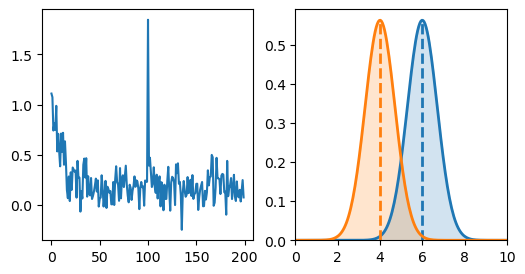

In [178]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(NewThompsonSampling([b.var for b in mab], buffer_size=30), mab) for _ in range(50)]
mean_regret = np.mean(regret, axis=0)
print(f'sum of regret: {np.sum(mean_regret)}')
plot(mean_regret, mab)